In [1]:
import librosa
import sounddevice as sd
import matplotlib.pyplot as plt
import torch
import soundfile as sf

In [2]:
sr = 16000

## plot and print tools

In [3]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [4]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [5]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()


# rir test

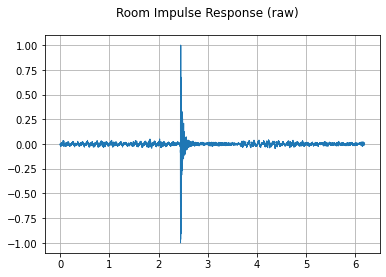

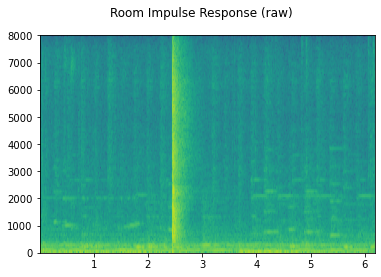

In [6]:
rir_raw,_ = librosa.load('./dataset/rir_data.wav',sr)

plot_waveform(rir_raw.reshape(1,-1), sr, title="Room Impulse Response (raw)", ylim=None)
plot_specgram(rir_raw.reshape(1,-1), sr, title="Room Impulse Response (raw)")
sd.play(rir_raw,sr)

Shape: (1, 4160)
Dtype: torch.float32
 - Max:      0.139
 - Min:     -0.139
 - Mean:    -0.000
 - Std Dev:  0.016

tensor([[ 0.0029,  0.0033,  0.0033,  ..., -0.0025, -0.0024, -0.0023]])



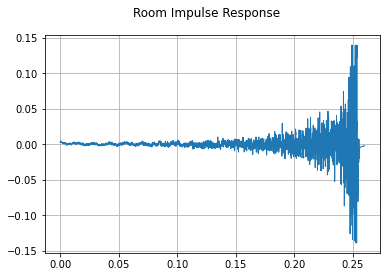

In [7]:
rir = torch.from_numpy( rir_raw[int(sr * 2.44) : int(sr * 2.7)].reshape(1,-1) )
# print(rir.shape)
rir = rir / torch.norm(rir, p=2)
rir = torch.flip(rir,[1])

print_stats(rir)
plot_waveform(rir, sr, title="Room Impulse Response", ylim=None)
# sf.write('./outputs/room_component.wav',rir.numpy().reshape(-1),sr,'PCM_16')

In [8]:
speech, _ = librosa.load('./dataset/target.wav',sr)
speech = torch.from_numpy(speech.reshape(1,-1))
print(speech.shape)
speech_ = torch.nn.functional.pad(speech, (rir.shape[1] - 1, 0))
print(speech.shape)

augmented = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]
print(augmented.shape)

torch.Size([1, 57600])
torch.Size([1, 57600])
torch.Size([1, 57600])


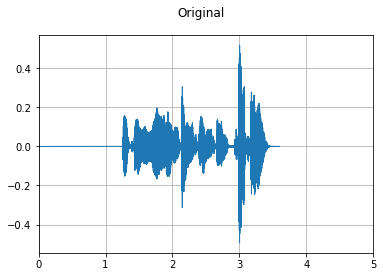

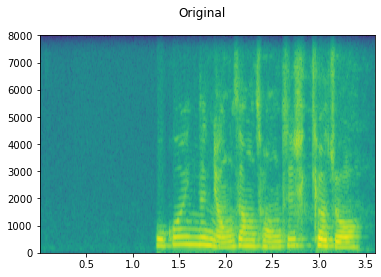

In [9]:
plot_waveform(speech, sr, title="Original", xlim=(0,5))
plot_specgram(speech, sr, title="Original")
# sd.play(speech.reshape(-1).numpy(),sr)

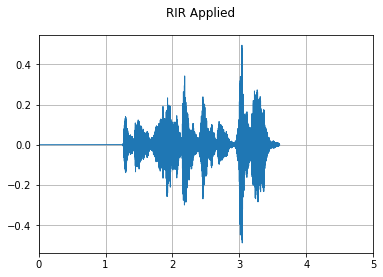

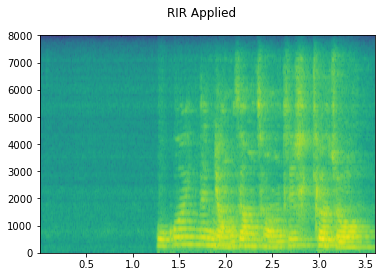

In [10]:
plot_waveform(augmented, sr, title="RIR Applied", xlim=(0,5))
plot_specgram(augmented, sr, title="RIR Applied")
# sd.play(augmented.reshape(-1).numpy(),sr)
# sf.write('./outputs/rir_applied.wav',augmented.reshape(-1).numpy(),sr,'PCM_16')